In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from pylift import TransformedOutcome
import warnings
import sys


warnings.filterwarnings('ignore')
DATA_PATH = ''  # Ваш путь к файлу

In [2]:
def load_and_preprocess_data(file_path, sample_frac=1.0, chunksize=1000000):
    """
    Загружает и предобрабатывает данные Criteo Uplift Prediction Dataset по частям.

    Args:
        file_path (str): Путь к CSV-файлу.
        sample_frac (float): Доля данных для обработки. Используйте 1.0 для всех данных.
                             Для тестирования или при MemoryError уменьшите (например, до 0.1).
        chunksize (int): Размер чанка для чтения данных.

    Returns:
        pd.DataFrame: Предобработанный DataFrame.
    """
    print(f"Загрузка данных из {file_path} (выборка: {sample_frac * 100:.0f}%)...")
    try:
        chunks = []
        for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunksize)):
            chunks.append(
                chunk.sample(frac=sample_frac, random_state=42 + i))
        df = pd.concat(chunks, ignore_index=True)
        print(f"Загружено {df.shape[0]} записей.")
    except FileNotFoundError:
        raise FileNotFoundError(f"Ошибка: Файл '{file_path}' не найден. Пожалуйста, проверьте путь к файлу.")
    except Exception as e:
        raise Exception(f"Ошибка при загрузке данных: {e}")

    # Проверка на наличие ожидаемых столбцов
    expected_columns = [f'f{i}' for i in range(12)] + ['treatment', 'conversion', 'visit', 'exposure']
    missing_columns = [col for col in expected_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Данные не содержат всех ожидаемых столбцов. Отсутствуют: {', '.join(missing_columns)}")

    # Обработка пропущенных значений
    print("\nПропуски в данных:")
    null_counts = df.isnull().sum()
    print(null_counts[null_counts > 0])
    if null_counts.sum() > 0:
        df_before_dropna = df.shape[0]
        df = df.dropna()
        print(f"Удалено {df_before_dropna - df.shape[0]} записей с пропущенными значениями.")
    else:
        print("Пропущенных значений нет.")

    # Удаление "невалидных" записей (treatment=0, exposure=1)
    invalid_exposure_count = df[(df['treatment'] == 0) & (df['exposure'] == 1)].shape[0]
    if invalid_exposure_count > 0:
        print(f"Удалено {invalid_exposure_count} записей, где treatment=0 и exposure=1 (невалидный показ в контрольной группе).")
        df = df[~((df['treatment'] == 0) & (df['exposure'] == 1))]
    else:
        print("Невалидных записей (treatment=0, exposure=1) не найдено.")

    print("\nОписательная статистика признаков:")
    print(df.describe())

    print("\nРаспределение treatment:")
    print(df['treatment'].value_counts(normalize=True))
    print("\nРаспределение visit (целевая переменная):")
    print(df['visit'].value_counts(normalize=True))
    print("\nРаспределение conversion:")
    print(df['conversion'].value_counts(normalize=True))

    return df

In [3]:
def perform_eda(df, low_var_features):
    """
    Выполняет разведочный анализ данных (EDA) с визуализациями.

    Args:
        df (pd.DataFrame): DataFrame с данными.
        low_var_features (list): Список признаков с низкой вариативностью.
    """
    print("\nEDA: Анализ распределения признаков")
    numeric_features = [f'f{i}' for i in range(12) if f'f{i}' in df.columns and f'f{i}' != 'f3']

    # Гистограммы для всех числовых признаков
    plt.figure(figsize=(18, 12))
    for i, col in enumerate(numeric_features):
        plt.subplot(3, 4, i + 1)
        sns.histplot(df[col], bins=50, kde=True, color='skyblue')
        plt.title(f'Распределение {col}', fontsize=12)
        plt.xlabel(col, fontsize=10)
        plt.ylabel('Количество', fontsize=10)
    plt.tight_layout()
    plt.suptitle('Гистограммы распределения числовых признаков', y=1.02, fontsize=16)
    plt.show()

    print("\nEDA: Корреляционная матрица признаков")
    corr_cols = numeric_features + ['treatment', 'visit']
    plt.figure(figsize=(12, 10))
    sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('Корреляционная матрица признаков, treatment и visit (без f3)', fontsize=14)
    plt.show()

    print("\nEDA: Анализ распределения 'visit' по 'treatment' для каждого низковариативного признака")

    # Анализ низковариативных признаков
    for col in low_var_features:
        if col not in df.columns:
            print(f"Предупреждение: Признак '{col}' не найден в DataFrame для EDA.")
            continue

        print(f"\nАнализ '{col}':")
        unique_vals = df[col].nunique()
        print(f"Количество уникальных значений для {col}: {unique_vals}")

        if unique_vals <= 1:
            print(
                f"Признак '{col}' имеет только одно уникальное значение. Он не будет биннирован для анализа NWOE/NIV и малоинформативен.")
            continue

        temp_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
        try:
            df[f'{col}_temp_binned'] = temp_discretizer.fit_transform(df[[col]]).astype(int)
        except ValueError as e:
            print(f"Не удалось биннировать {col} для EDA: {e}. Возможно, недостаточно уникальных значений.")
            continue

        plt.figure(figsize=(8, 5))
        sns.barplot(data=df, x=f'{col}_temp_binned', y='visit', hue='treatment', palette='viridis', ci=None)
        plt.title(f'Среднее "visit" по бинам {col} и группам treatment')
        plt.xlabel(f'{col} (Бины)')
        plt.ylabel('Среднее "visit"')
        plt.show()
        df.drop(columns=[f'{col}_temp_binned'], inplace=True)  # Удаляем временный столбец

    print("\nEDA завершен.")

In [4]:
def calculate_nwoe_niv(df, features, n_bins_default=5, n_bins_low_var=2, smoothing_alpha=0.01):
    """
    Рассчитывает NWOE и NIV для признаков с использованием pylift.

    Args:
        df (pd.DataFrame): DataFrame с данными.
        features (list): Список признаков.
        n_bins_default (int): Количество бинов для признаков с высокой вариативностью.
        n_bins_low_var (int): Количество бинов для признаков с низкой вариативностью.
        smoothing_alpha (float): Коэффициент сглаживания для предотвращения деления на ноль в WOE.

    Returns:
        tuple: Словари NWOE и NIV, тренировочный и тестовый DataFrame.
    """
    train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
    print(f"\nРазмер тренировочного набора: {train_df.shape[0]}, тестового: {test_df.shape[0]}")

    low_var_features = ['f1', 'f4', 'f5', 'f7', 'f10', 'f11']  # Это список из вашего кода

    binned_features = []
    print("\nБиннинг признаков...")
    for col in features:
        binned_col_name = f'{col}_binned'

        # Проверяем уникальные значения перед биннингом
        if train_df[col].nunique() < n_bins_low_var and col in low_var_features:
            print(f"Предупреждение: Признак '{col}' имеет всего {train_df[col].nunique()} уникальных значений. "
                  f"Биннинг может создать меньше бинов, чем запрошено ({n_bins_low_var}).")
            current_n_bins = max(1, train_df[col].nunique())
            discretizer = KBinsDiscretizer(n_bins=current_n_bins, encode='ordinal', strategy='quantile')
        elif col in low_var_features:
            discretizer = KBinsDiscretizer(n_bins=n_bins_low_var, encode='ordinal', strategy='quantile')
        else:
            discretizer = KBinsDiscretizer(n_bins=n_bins_default, encode='ordinal', strategy='quantile')

        try:
            train_df[binned_col_name] = discretizer.fit_transform(train_df[[col]]).astype(int)
            test_df[binned_col_name] = discretizer.transform(test_df[[col]]).astype(int)
            binned_features.append(binned_col_name)
        except ValueError as e:
            print(f"Ошибка биннинга для признака '{col}': {e}. Пропускаем этот признак для NWOE/NIV.")
            continue

    if not binned_features:
        raise ValueError("После биннинга не осталось подходящих признаков для расчета NWOE/NIV.")

    model_df = train_df[binned_features + ['treatment', 'visit']].copy()

    try:
        uplift_model = TransformedOutcome(
            model_df,
            col_treatment='treatment',
            col_outcome='visit'
        )
        uplift_model.fit()
        print("\nQINI-кривая (показывает способность модели идентифицировать Uplift):")
        uplift_model.plot_qini()
        plt.show()
    except Exception as e:
        print(f"Ошибка при инициализации или обучении uplift-модели (pylift): {e}")
        print("Возможно, недостаточно вариативности в данных или проблемы с библиотекой.")
        pass

    nwoe_dict = {}
    niv_dict = {}

    print("\nРасчет NWOE и NIV для каждого биннированного признака...")
    for feature in binned_features:
        # Группировка данных для расчета WOE
        grouped_df = train_df.pivot_table(
            index=feature,
            columns='treatment',
            values='visit',
            aggfunc='mean'
        ).fillna(0)

        # Расчет WOE со сглаживанием
        grouped_df['prob_treated'] = grouped_df[1]
        grouped_df['prob_control'] = grouped_df[0]

        # Расчет WOE
        grouped_df['woe_treatment'] = np.log(
            (grouped_df['prob_treated'] + smoothing_alpha) / (grouped_df['prob_control'] + smoothing_alpha))

        # Общая доля visit
        overall_visit_rate = train_df['visit'].mean()

        # Расчет общей WOE
        overall_woe = np.log((overall_visit_rate + smoothing_alpha) / ((1 - overall_visit_rate) + smoothing_alpha))

        # Расчет NWOE
        grouped_df['nwoe'] = grouped_df['woe_treatment'] - overall_woe

        # Расчет доли популяции в каждом бине
        bin_counts = train_df[feature].value_counts(normalize=True)
        bin_counts = bin_counts.reindex(grouped_df.index, fill_value=0)  # Убедимся, что индексы совпадают

        # Расчет NIV
        niv = (grouped_df['nwoe'] * bin_counts).sum()

        bin_population = train_df.groupby(feature).size()
        print(f"\nНаселённость бинов для {feature}:")
        print(bin_population)
        print(f"NWOE значения для {feature}:\n{grouped_df['nwoe']}")

        nwoe_dict[feature] = grouped_df['nwoe']
        niv_dict[feature] = niv

    return nwoe_dict, niv_dict, train_df, test_df

In [5]:
def visualize_results(nwoe_dict, niv_dict, train_df):
    """
    Визуализирует результаты NWOE, NIV и ATE.

    Args:
        nwoe_dict (dict): Словарь с NWOE.
        niv_dict (dict): Словарь с NIV.
        train_df (pd.DataFrame): Тренировочный DataFrame.
    """
    print("\nВизуализация NWOE (Net Weight of Evidence)")
    num_features = len(nwoe_dict)
    cols = 4
    rows = int(np.ceil(num_features / cols))

    plt.figure(figsize=(cols * 4, rows * 3))
    for i, feature in enumerate(nwoe_dict.keys()):
        plt.subplot(rows, cols, i + 1)
        nwoe_dict[feature].plot(kind='bar', color='teal')
        plt.title(f'NWOE для {feature}', fontsize=10)
        plt.xlabel('Бин', fontsize=8)
        plt.ylabel('NWOE', fontsize=8)
        plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
        plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.suptitle('NWOE (Net Weight of Evidence) по бинам признаков', y=1.02, fontsize=16)
    plt.show()

    print("\nВизуализация NIV (Net Information Value)")
    niv_values = pd.Series(niv_dict).sort_values(ascending=False)
    plt.figure(figsize=(10, max(6, num_features * 0.5)))
    sns.barplot(x=niv_values.values, y=niv_values.index, palette='viridis')
    plt.title('Net Information Value (NIV) для признаков (по убыванию)', fontsize=14)
    plt.xlabel('NIV', fontsize=12)
    plt.ylabel('Признак', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    # Расчет и визуализация ATE
    ate_visit = train_df[train_df['treatment'] == 1]['visit'].mean() - train_df[train_df['treatment'] == 0]['visit'].mean()
    ate_conversion = train_df[train_df['treatment'] == 1]['conversion'].mean() - train_df[train_df['treatment'] == 0][
        'conversion'].mean()

    print(f"\nСредний эффект воздействия (ATE) для 'visit': {ate_visit:.6f}")
    print(f"Средний эффект воздействия (ATE) для 'conversion': {ate_conversion:.6f}")

    # Визуализация ATE
    ate_labels = ['ATE (Visit)', 'ATE (Conversion)']
    ate_values = [ate_visit, ate_conversion]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=ate_labels, y=ate_values, palette=['skyblue', 'lightcoral'])
    plt.title('Средний эффект воздействия (ATE) для "Visit" и "Conversion"', fontsize=14)
    plt.ylabel('Значение ATE', fontsize=12)
    plt.ylim(min(0, min(ate_values) * 1.2), max(ate_values) * 1.2)  # Адаптивные лимиты оси Y
    for index, value in enumerate(ate_values):
        plt.text(index, value, f'{value:.4f}', ha='center', va='bottom', fontsize=10)
    plt.show()

In [6]:
def main():
    try:
        df = load_and_preprocess_data(DATA_PATH)

        # Список признаков с низкой вариативностью
        low_var_features = ['f1', 'f4', 'f5', 'f7', 'f10', 'f11']
        perform_eda(df, low_var_features)

        # Признак 'f3' исключается
        features_for_nwoe = [f'f{i}' for i in range(12) if i != 3]
        print("\nНачинаем расчет NWOE и NIV...")

        nwoe_dict, niv_dict, train_df, test_df = calculate_nwoe_niv(df, features_for_nwoe,
                                                                    n_bins_default=5,
                                                                    n_bins_low_var=2,
                                                                    smoothing_alpha=1e-6)

        print("\nИтоговые значения NIV для каждого признака:")
        for feature, niv in niv_dict.items():
            print(f"{feature}: {niv:.4f}")

        visualize_results(nwoe_dict, niv_dict, train_df)
        print("\nАнализ успешно завершен!")

    except MemoryError:
        print("\nКРИТИЧЕСКАЯ ОШИБКА: Недостаточно памяти.")
        sys.exit(1)
    except FileNotFoundError as e:
        print(e)
        sys.exit(1)
    except ValueError as e:
        print(f"Ошибка в данных или конфигурации: {e}")
        sys.exit(1)
    except Exception as e:
        print(f"\nПроизошла непредвиденная ошибка: {e}")
        sys.exit(1)

Загрузка данных из /Users/igor/Downloads/Criteo data.csv (выборка: 100%)...
Загружено 13979592 записей.

Пропуски в данных:
Series([], dtype: int64)
Пропущенных значений нет.
Невалидных записей (treatment=0, exposure=1) не найдено.

Описательная статистика признаков:
                 f0            f1            f2            f3            f4  \
count  1.397959e+07  1.397959e+07  1.397959e+07  1.397959e+07  1.397959e+07   
mean   1.962030e+01  1.006998e+01  8.446582e+00  4.178923e+00  1.033884e+01   
std    5.377464e+00  1.047557e-01  2.993161e-01  1.336645e+00  3.433081e-01   
min    1.261636e+01  1.005965e+01  8.214383e+00 -8.398387e+00  1.028053e+01   
25%    1.261636e+01  1.005965e+01  8.214383e+00  4.679882e+00  1.028053e+01   
50%    2.192341e+01  1.005965e+01  8.214383e+00  4.679882e+00  1.028053e+01   
75%    2.443646e+01  1.005965e+01  8.723335e+00  4.679882e+00  1.028053e+01   
max    2.674526e+01  1.634419e+01  9.051962e+00  4.679882e+00  2.112351e+01   

                 f5 

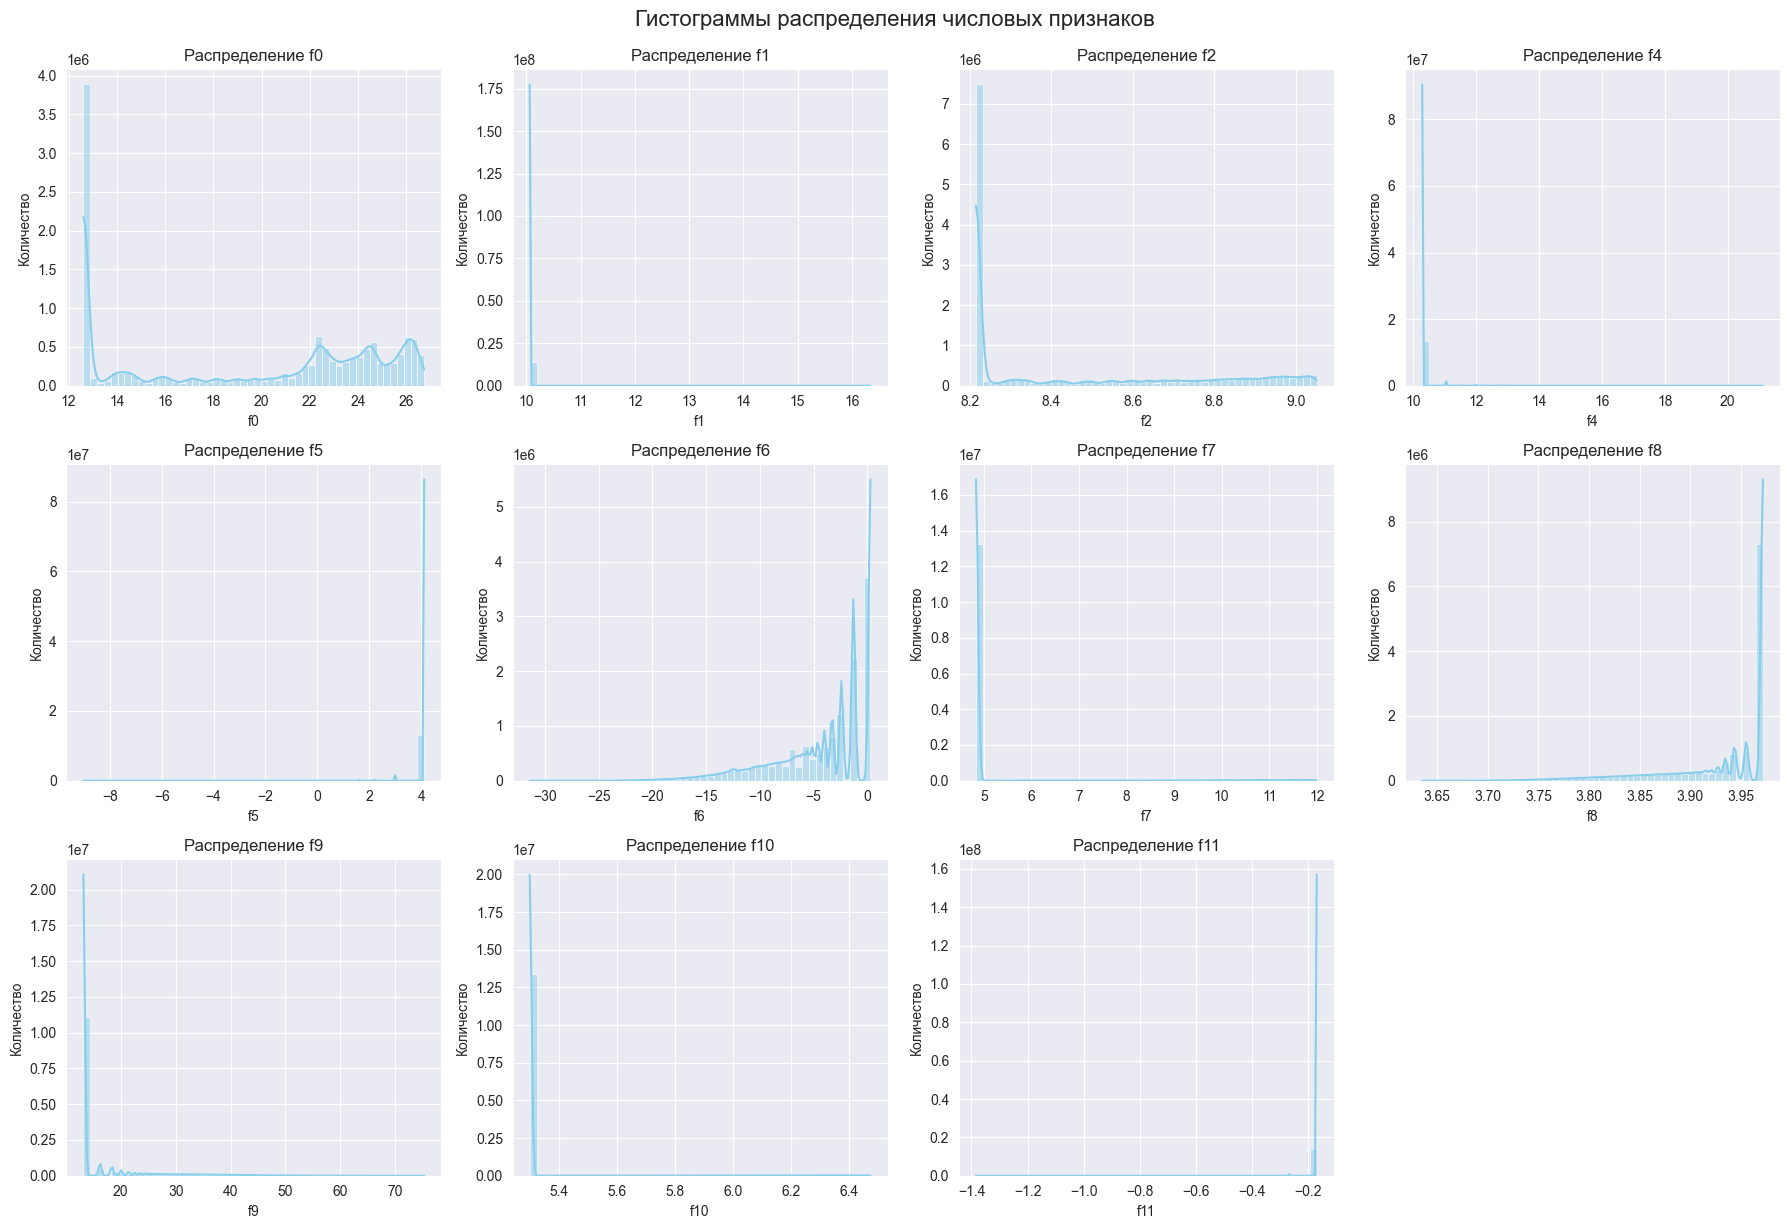


EDA: Корреляционная матрица признаков


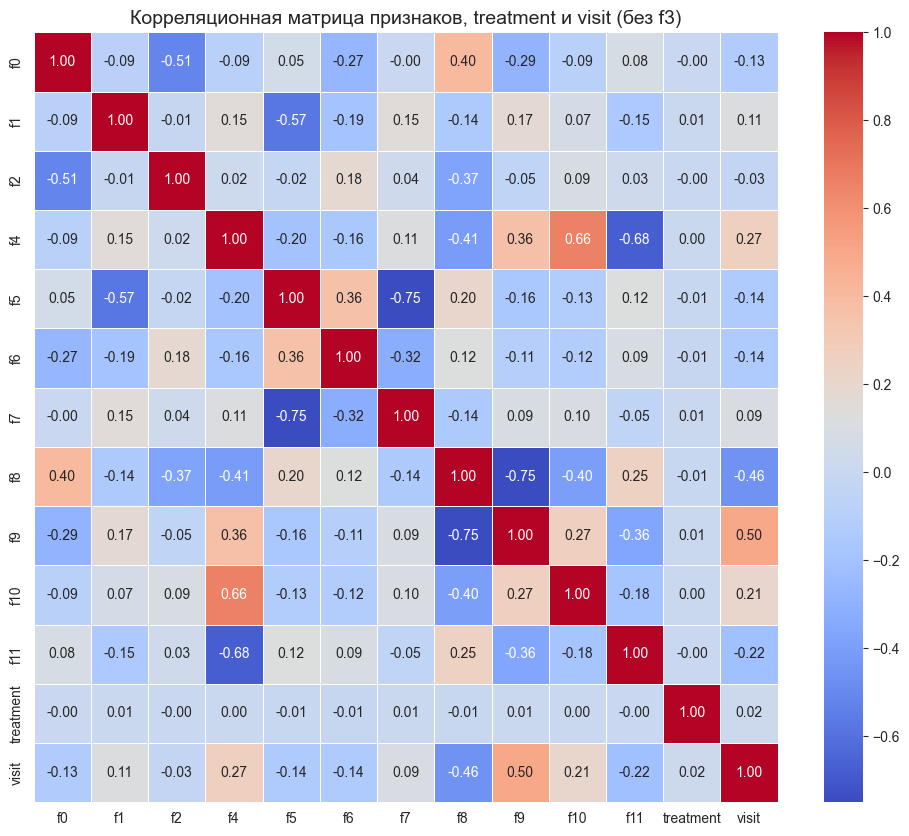


EDA: Анализ распределения 'visit' по 'treatment' для каждого низковариативного признака

Анализ 'f1':
Количество уникальных значений для f1: 60


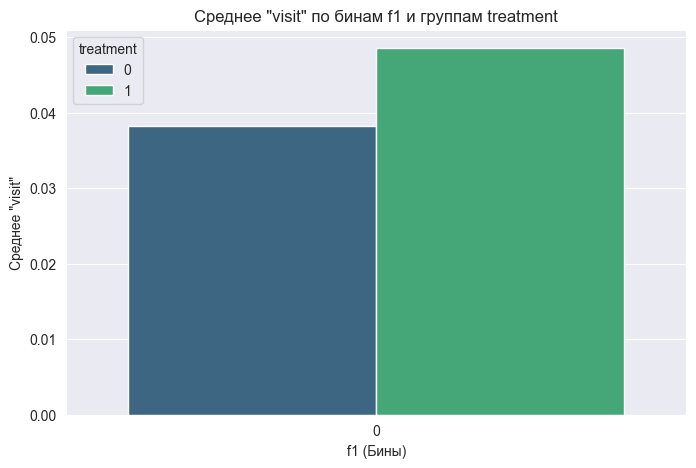


Анализ 'f4':
Количество уникальных значений для f4: 260


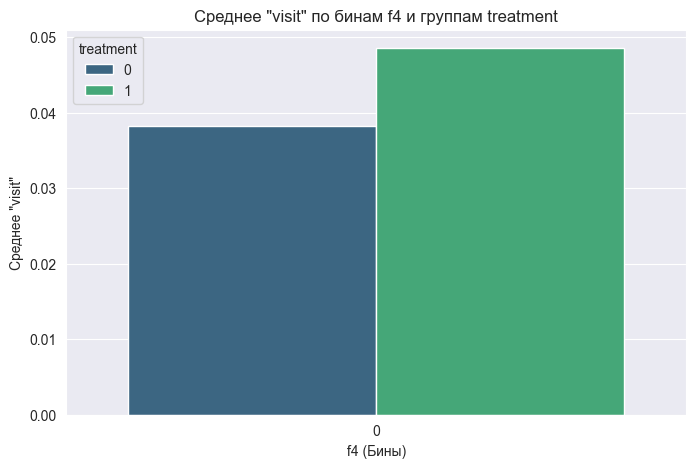


Анализ 'f5':
Количество уникальных значений для f5: 132


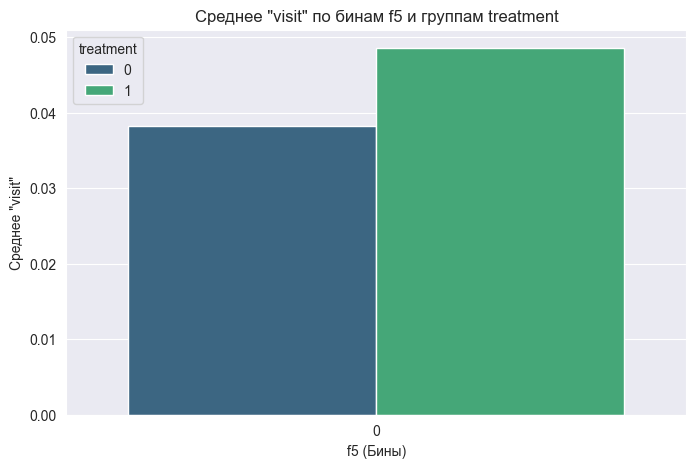


Анализ 'f7':
Количество уникальных значений для f7: 622143


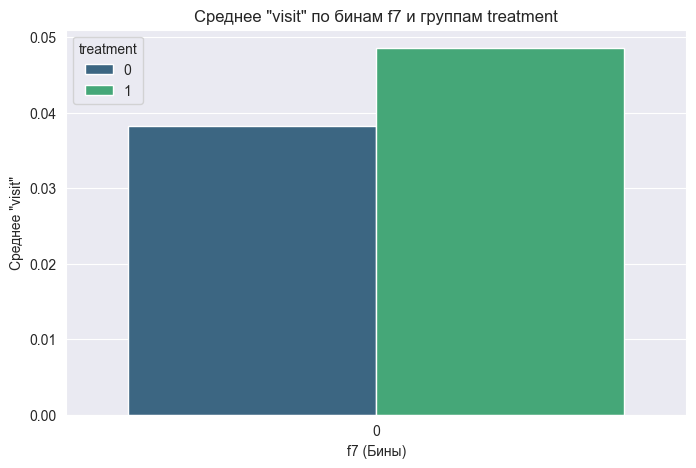


Анализ 'f10':
Количество уникальных значений для f10: 517372


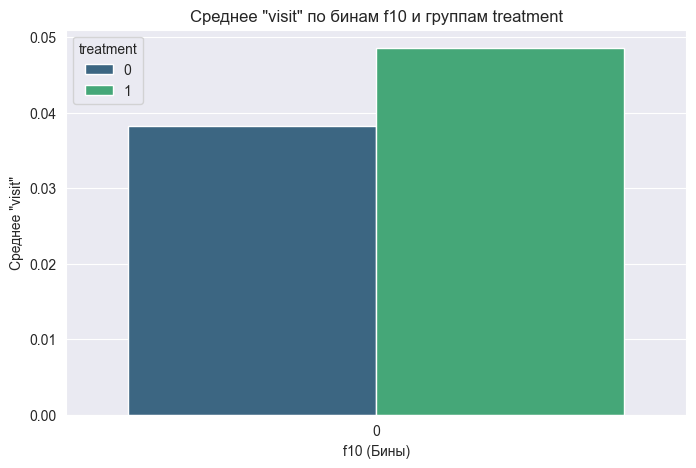


Анализ 'f11':
Количество уникальных значений для f11: 136


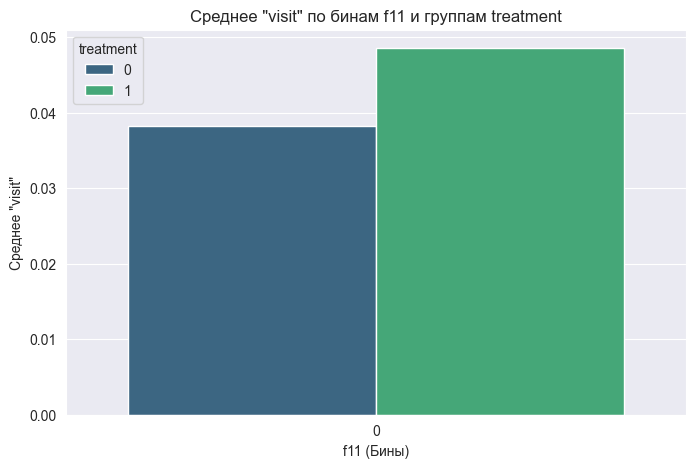


EDA завершен.

Начинаем расчет NWOE и NIV...

Размер тренировочного набора: 9785714, тестового: 4193878

Биннинг признаков...

QINI-кривая (показывает способность модели идентифицировать Uplift):


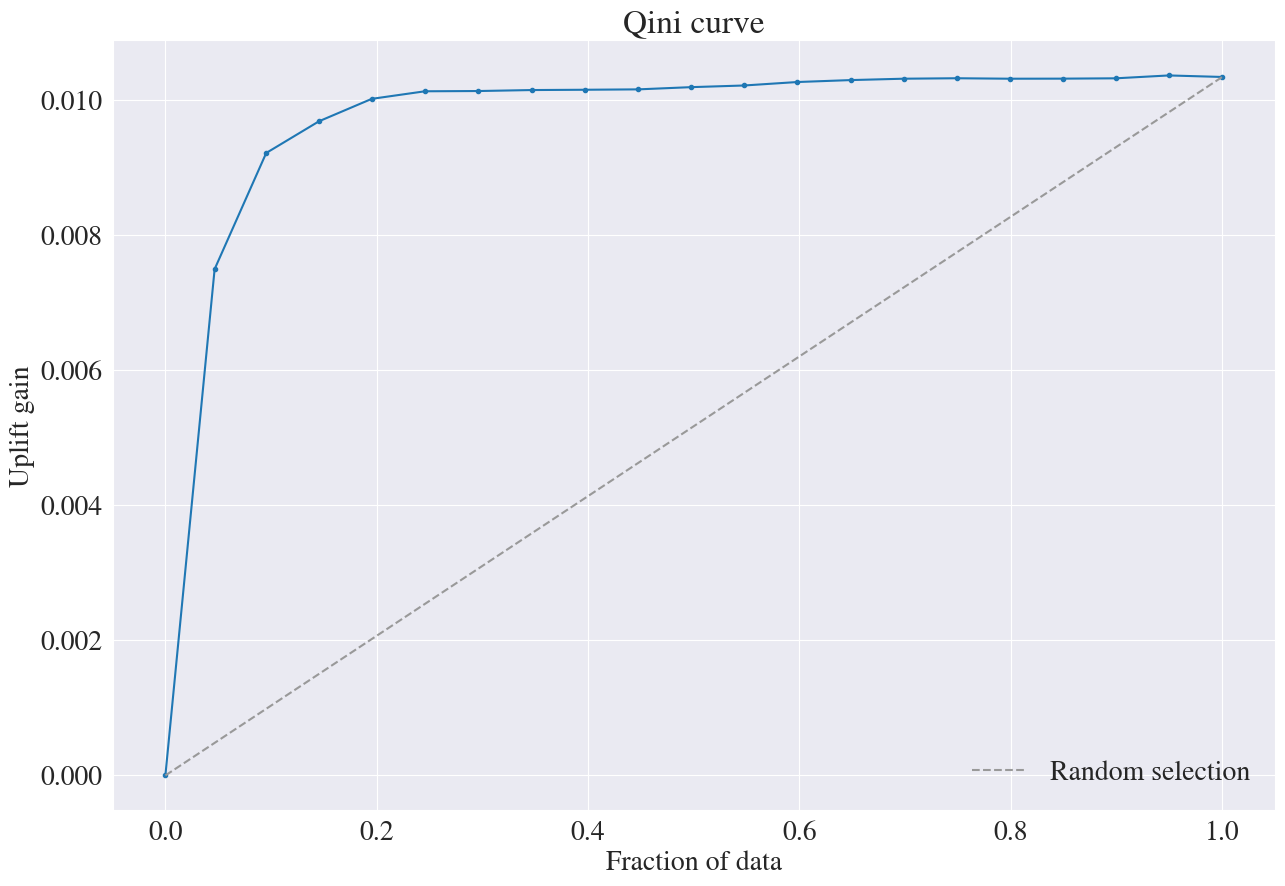


Расчет NWOE и NIV для каждого биннированного признака...

Населённость бинов для f0_binned:
f0_binned
0    3910609
1    1970316
2    1956555
3    1948234
dtype: int64
NWOE значения для f0_binned:
f0_binned
0    3.270326
1    3.220524
2    3.136969
3    3.063473
Name: nwoe, dtype: float64

Населённость бинов для f1_binned:
f1_binned
0    9785714
dtype: int64
NWOE значения для f1_binned:
f1_binned
0    3.24513
Name: nwoe, dtype: float64

Населённость бинов для f2_binned:
f2_binned
0    5869884
1    1960250
2    1955580
dtype: int64
NWOE значения для f2_binned:
f2_binned
0    3.221502
1    3.262021
2    3.319989
Name: nwoe, dtype: float64

Населённость бинов для f4_binned:
f4_binned
0    9785714
dtype: int64
NWOE значения для f4_binned:
f4_binned
0    3.24513
Name: nwoe, dtype: float64

Населённость бинов для f5_binned:
f5_binned
0    9785714
dtype: int64
NWOE значения для f5_binned:
f5_binned
0    3.24513
Name: nwoe, dtype: float64

Населённость бинов для f6_binned:
f6_binned
0    19410

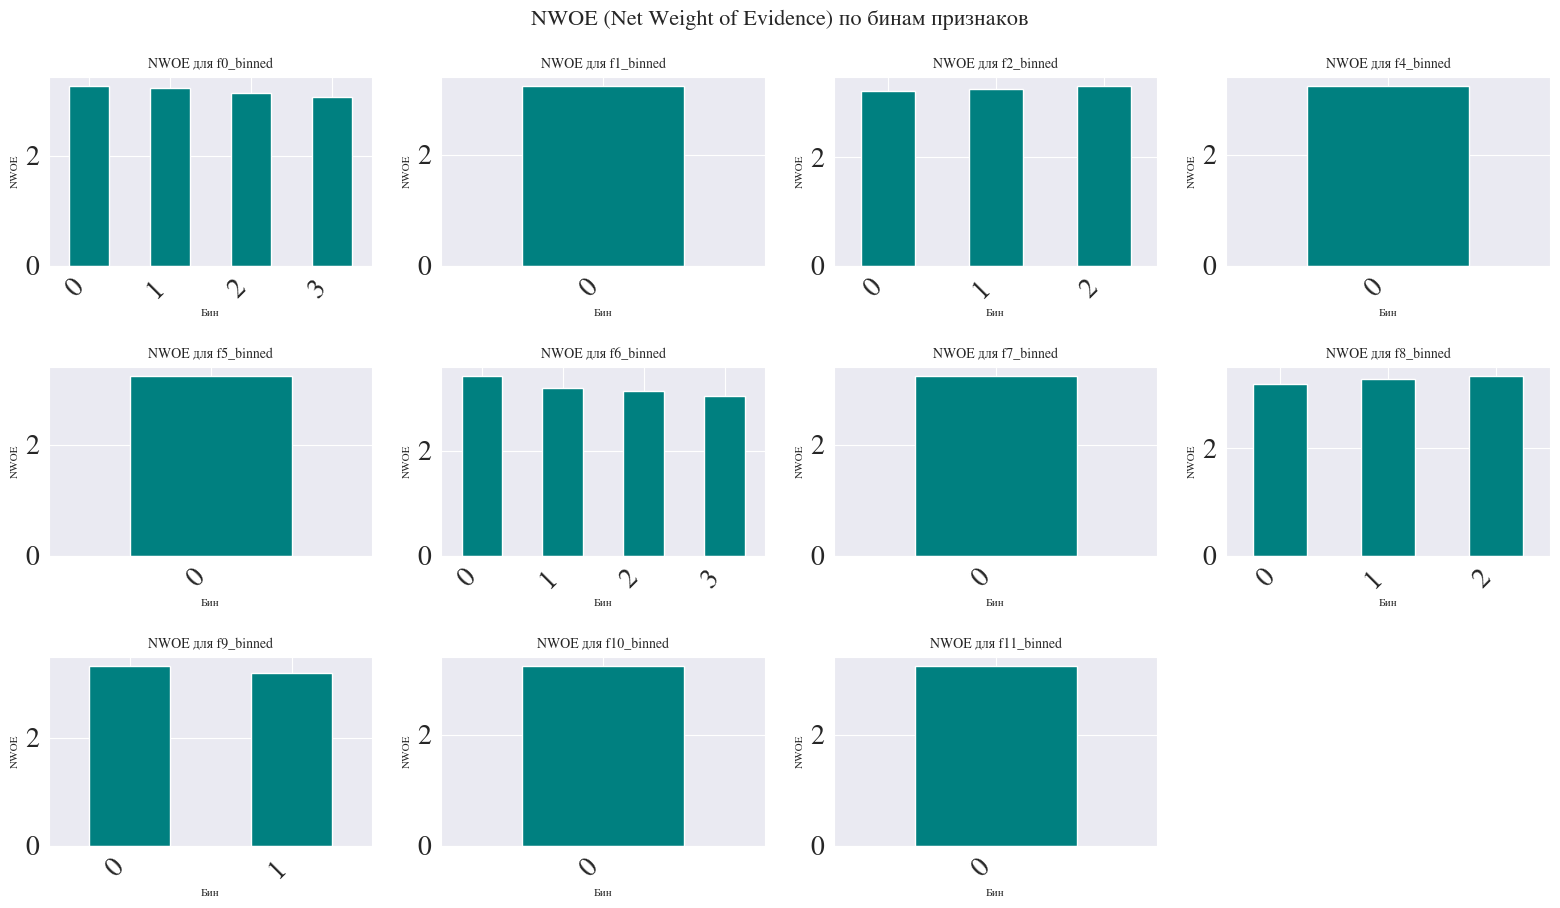


Визуализация NIV (Net Information Value)


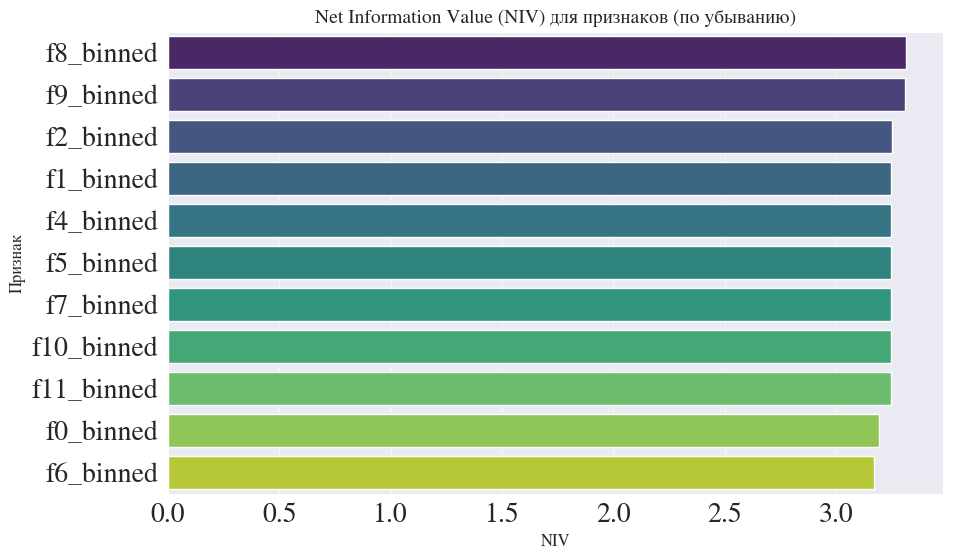


Средний эффект воздействия (ATE) для 'visit': 0.010145
Средний эффект воздействия (ATE) для 'conversion': 0.001115


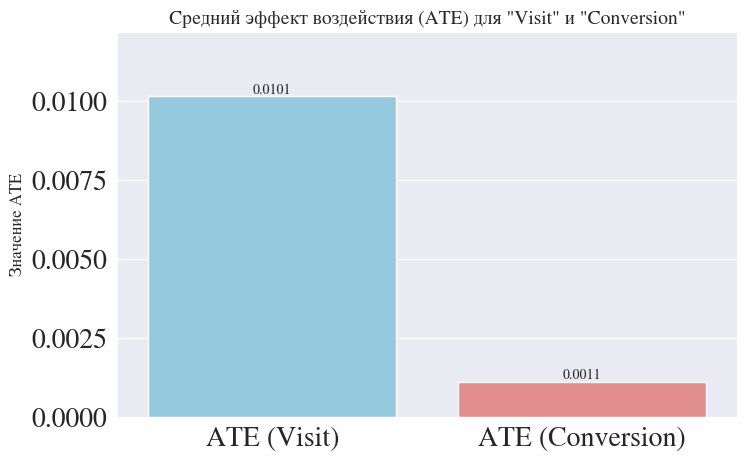


Анализ успешно завершен!


In [7]:
if __name__ == "__main__":
    main()